<a href="https://colab.research.google.com/github/sayan0506/Task-2-Internship/blob/main/IIITD_Task_2_test_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model testing

In [49]:
# install wandb
!pip install --upgrade wandb

     |████████████████████████████████| 2.1MB 8.3MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 133kB 46.1MB/s 
     |████████████████████████████████| 163kB 48.0MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=2d0011a8bbef90ecc4dec8476a3cb6ddfa3ecea22e387b77e68050b4a8377b43
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=840096167f37ec924f647e17f1dc9e9ab293fa29466c7274da7d2adc7503c602
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


Import dependencies

In [2]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

import tensorflow as tf
import keras
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

#from livelossplot import PlotLossesKeras
from keras.models import model_from_json

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm

Improve Reproducibility

In [3]:
# improve reproducibility and make it more deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by rmoving stochasticity")% 2**32 -1)

Setup wandb

In [50]:
import wandb
from wandb.keras import WandbCallback

# authorize
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Download Dataset

In [6]:
!wget https://www.dropbox.com/s/qg95ta6dm3f1mek/testPart1.zip?dl=0

--2021-04-24 10:38:00--  https://www.dropbox.com/s/qg95ta6dm3f1mek/testPart1.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qg95ta6dm3f1mek/testPart1.zip [following]
--2021-04-24 10:38:00--  https://www.dropbox.com/s/raw/qg95ta6dm3f1mek/testPart1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucce1750d8ef0462ba816bbee8f1.dl.dropboxusercontent.com/cd/0/inline/BNMweMCVZg1hFc7kGRpxgxc7Iucm80Psxay7XBG16dI7z2PTLaBnGY6EpnJI-Pounp2mIe1ol-aq0BiMm1YSYzMSna8LLxrupz0euLpeZFsyuC_K4i22c27MeuFGoHAvDcF3d3DmPu2RSUhUxVsi0jvd/file# [following]
--2021-04-24 10:38:00--  https://ucce1750d8ef0462ba816bbee8f1.dl.dropboxusercontent.com/cd/0/inline/BNMweMCVZg1hFc7kGRpxgxc7Iucm80Psxay7XBG16dI7z2PTLaBnGY6EpnJI-Pounp2mIe1ol-aq0BiMm1

Unzipping and loading

In [7]:
# defining unzipping function
def unzip(zip_file, content_dir):
  if not os.path.isdir(content_dir):
    os.mkdir(content_dir)

  # unzipping
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(content_dir)

In [8]:

# zipfile path
zip_file = '/content/testPart1.zip?dl=0'

# content directory
content_dir = 'master_data'

# calling unzip
unzip(zip_file, content_dir)

Data inspection

In [18]:

# master directory path
img_dir = '/content/master_data/test/'

# classifiers list
print(f'List of classifiers\n{sorted(os.listdir(img_dir))}')
print(f'Total {len(os.listdir(img_dir))} classifiers are there')

List of classifiers
['Sample001', 'Sample002', 'Sample003', 'Sample004', 'Sample005', 'Sample006', 'Sample007', 'Sample008', 'Sample009', 'Sample010', 'Sample011', 'Sample012', 'Sample013', 'Sample014', 'Sample015', 'Sample016', 'Sample017', 'Sample018', 'Sample019', 'Sample020', 'Sample021', 'Sample022', 'Sample023', 'Sample024', 'Sample025', 'Sample026', 'Sample027', 'Sample028', 'Sample029', 'Sample030', 'Sample031', 'Sample032', 'Sample033', 'Sample034', 'Sample035', 'Sample036', 'Sample037', 'Sample038', 'Sample039', 'Sample040', 'Sample041', 'Sample042', 'Sample043', 'Sample044', 'Sample045', 'Sample046', 'Sample047', 'Sample048', 'Sample049', 'Sample050', 'Sample051', 'Sample052', 'Sample053', 'Sample054', 'Sample055', 'Sample056', 'Sample057', 'Sample058', 'Sample059', 'Sample060', 'Sample061', 'Sample062']
Total 62 classifiers are there


Data Pre-processing

In [19]:

# define batch size based on which train datagen will prepare the data
batch_size = 32

In [25]:
# creating imagedatagenerator object using keras
train_datagen = ImageDataGenerator(rotation_range=None,
                                   width_shift_range = None,
                                   height_shift_range = None,
                                   brightness_range = None,
                                   zoom_range = 0.0,
                                   rescale = 1./255.,
                                   preprocessing_function = None,
                                   dtype = np.float32
                                   #validation_split = 1.0 #using validation split on same train data for validation
                                   )

# provide same seed and keyword arguments to the fit and flow methods 
seed = 1

# obtaining images from tarin directory and apply augmentation using train datagen to create batches
test_generator = train_datagen.flow_from_directory(directory=img_dir,
                                                    target_size = (28,28),
                                                    color_mode = "grayscale", # images are converted to grayscale
                                                    classes = None,
                                                    class_mode = "sparse", # sparse categorical helps to reduce space
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    seed = seed,
                                                    subset = 'training'
)


Found 930 images belonging to 62 classes.


Visualization

In [27]:
def img_label_samples(train_generator, class_count = 62):
  '''
  Fetches 1st sample of each class from 0 to 61
  Along with the class label or id
  Takes total class samples to be visualized 
  Batch count as attributes
  '''
  # total batches in the train datagenerator
  batch_count = len(train_generator)
  # image list initialization
  img_list = []
  # labels list
  labels = []

  for cls in range(class_count):
    for batch in range(batch_count):
      # traversing through image label or class id
      # O-> Batch, 1-> Class(for 1, 0 for image), 2-> Index of each image in the batch(0 to 31)
      for i, j in enumerate(train_generator[batch][1][:]):
        if int(j)==cls:
          img_list.append(train_generator[batch][0][i])
          labels.append(int(j))
          break
      if int(j) == cls:
        break
  return img_list, labels

In [28]:
# obtain image and label list from train_generator
img_list, labels = img_label_samples(test_generator)

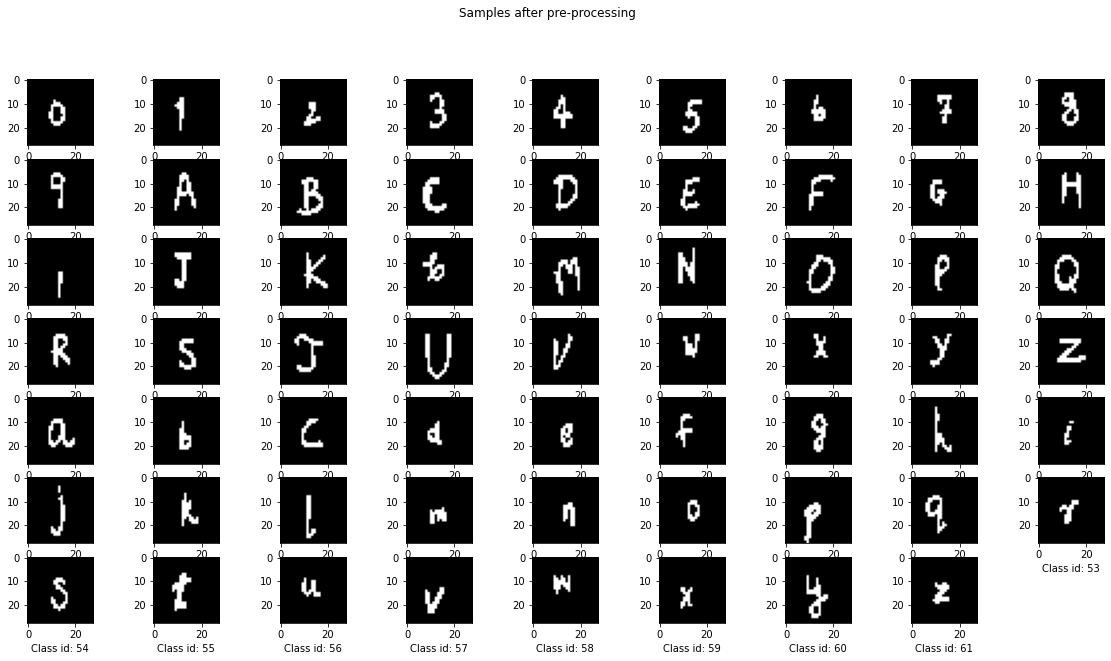

In [29]:

def vis_gen(img_list, labels):
  '''
  62 samples will be visualized
  '''
  cols = 9
  rows = np.ceil(len(img_list)/9)
  fig = plt.figure(figsize=(20,10))
  fig.suptitle('Samples after pre-processing')
  fig.tight_layout()
  for i, c in enumerate(img_list):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(np.squeeze(c), cmap = 'binary')
    plt.xlabel(f'Class id: {labels[i]}')

  plt.show()

# calling the visualization fn
vis_gen(img_list, labels)

Mount the drive
https://drive.google.com/drive/u/0/folders/1y-nmh27fHB71eO622D9qgxowI8mU-0OY


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model hyperparameters and initialization

In [30]:
# input image shape = (28,28,1)
input_shape = train_generator.image_shape
# num_classes = 62
num_classes = train_generator.num_classes
print(f'Model input_shape {input_shape}')
print(f'Number of output class {num_classes}')

Model input_shape (28, 28, 1)
Number of output class 62


In [43]:

best_weights_file = '/content/drive/MyDrive/IIITD Assignment/Best Master model section 1/Master_training_epoch_20.hdf5'
#random_initialized_weights_file = '/content/drive/MyDrive/Agriculture AI/Potato Model/model_initial.h5'

'''
# saving model architecture as json
model_json = model.to_json()
with open("model_final.json", "w") as json_file:
  json_file.write(model_json)
'''

model_json_file = '/content/drive/MyDrive/IIITD Assignment/Model Json File/model_final.json'

print(f'Best weight file for the model {best_weights_file}')
#print(f'Best weight file for the model {random_initialized_weights_file}')
print(f'Model json file {model_json_file}')

Best weight file for the model /content/drive/MyDrive/IIITD Assignment/Best Master model section 1/Master_training_epoch_20.hdf5
Model json file /content/drive/MyDrive/IIITD Assignment/Model Json File/model_final.json


In [44]:
# defining the hyperparameters

# initial/ optimal LR
learning_rate = 0.001 # tobe tuned using scheduler
epochs = 20
loss_fn = 'sparse_categorical_crossentropy'

In [45]:

# open json file in read mode
json_file = open(model_json_file, 'r')
# read the file
loaded_model_json = json_file.read()
# close the file
json_file.close()

# load the model
model = model_from_json(loaded_model_json)

# summary check
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928

In [55]:
'''
Instruction: Initialize everytime before using wandbcallback and run.join()
'''
# initialize wandb with the project

run = wandb.init(project = 'Master Testing 2.1',
                 config = {
                     "learning_rate": learning_rate,
                     "epochs": epochs,
                     "batch_size": train_generator.batch_size,
                     "loss_function": loss_fn,
                     "architecture": "CNN",
                     "dataset": 'Trainset'
                 })

# will be used to configure the experiment log for wandb tracking 
config = wandb.config


In [53]:
# compile the model
# defining the optimizer 
optimizer = Adam(learning_rate)
model.compile(optimizer=optimizer, loss = loss_fn, metrics = ['acc'])

In [56]:
# final evaluation check
# based on final validation accuracy we are picking the model
test_loss, test_acc = model.evaluate(test_generator)

# wandb log analysis
wandb.log({'Test error': round((1 - test_acc) * 100, 2)})

run.join()

30/30 [==============================] - 15s 482ms/step - loss: 2.2446 - acc: 0.4355


Test error,56.45
_runtime,18
_timestamp,1619263888
_step,0


Test error,▁
_runtime,▁
_timestamp,▁
_step,▁
